In [10]:
import glob
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator
from tabulate import tabulate
import re
group_name = {"virt_sym":"Chronokernel-virt", "virt_ksys": "ksys_write-virt", "baremetal_sym": "Chronokernel", "baremetal_ksys": "ksys_write", "redis_ksys": "ksys_write", "redis_interpose": "interposed ksys_write", "redis_linux": "Linux", "redis_sym": "Chronokernel"}

In [11]:
def clean_data(file_name):
    fin = open(file_name, "rt")
    fout = open("out.txt", "wt")

    for line in fin:
        if line[0] != '#':
            fout.write(' '.join(line.split()) + '\n')
    fin.close()
    fout.close()
    
    os.remove(file_name)
    os.rename("out.txt", file_name)

In [16]:
def load_data(test_name, cores=1, run_number=-1,discard_outliers=True):
    if run_number >= 0:
        file_name = 'latency_data/{}/{}/baseline_FULL_RUN_{}.txt'.format(cores, test_name, run_number)
    else:
        file_name = 'latency_data/{}/{}/baseline_FULL_RUN_*.txt'.format(cores, test_name)
    files = glob.glob(file_name)
    data = []
    for file in files:
        clean_data(file)
        graph = pd.read_csv(file, sep=' ')
        if run_number >= 0:
            graph['System'] = 'run{}'.format(run_number)
        else:
            graph['System'] = group_name[test_name]
        data.append(graph)
    if(run_number < 0):
        return data
    else:
        return graph

In [26]:
virt_sym = {}
virt_ksys = {}
baremetal_sym = {}
baremetal_ksys = {}

for i in range(0,4):
    virt_sym[i] = load_data("virt_sym", run_number=i)
    virt_ksys[i] = load_data("virt_ksys", run_number=i)
    
for i in range(0,3):
    baremetal_sym[i] = load_data("baremetal_sym", run_number=i)
    baremetal_ksys[i] = load_data("baremetal_ksys", run_number=i)
    #redis_ksys[i] = load_data("redis_ksys", run_number=i)

virt_sym_all = load_data("virt_sym")
virt_memcached_all = load_data("virt_ksys")
baremetal_sym_all = load_data("baremetal_sym")
baremetal_memcached_all = load_data("baremetal_ksys")

redis_interpose = load_data("redis_interpose")
redis_linux = load_data("redis_linux")
redis_sym = load_data("redis_sym")
redis_ksys = load_data("redis_ksys")

redis_all = redis_interpose + redis_linux + redis_sym

In [ ]:
graph_data ={}
for i in range(len(redis_all)):
    graph_data[i] = pd.DataFrame(redis_all[i],columns=['Percentile', 'Value', 'System'])
    graph_data[i] = graph_data[i][graph_data[i]["Percentile"] < 0.995].copy()

graph = pd.concat(graph_data, ignore_index=True)

fig = sns.lineplot(y="Value", x="Percentile", data=graph, hue="System")

fig.set(title="REDIS SHORTCUTTED LATENCY")

plt.xlabel('Percentile')
plt.ylabel('Latency (us)')
plt.ylim(0,7)
plt.xlim(0,0.999)
plt.tight_layout()
plt.savefig("graphs/redis_shortcut.png")

    Percentile  Value System
0     0.000000   0.06   run1
1     0.050000   1.41   run1
2     0.100000   1.43   run1
3     0.150000   1.45   run1
4     0.200000   1.46   run1
..         ...    ...    ...
73    0.993359   2.96   run1
74    0.993750   2.96   run1
75    0.994141   2.98   run1
76    0.994531   2.99   run1
77    0.994922   2.99   run1

[78 rows x 3 columns]
    Percentile  Value System
0     0.000000   0.06   run2
1     0.050000   1.40   run2
2     0.100000   1.42   run2
3     0.150000   1.44   run2
4     0.200000   1.46   run2
..         ...    ...    ...
73    0.993359   2.90   run2
74    0.993750   2.91   run2
75    0.994141   2.91   run2
76    0.994531   2.93   run2
77    0.994922   2.93   run2

[78 rows x 3 columns]


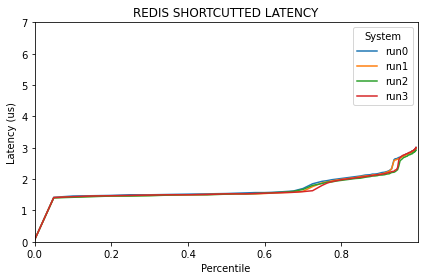

In [7]:
graph_data ={}
for i in range(4):
    graph_data[i] = pd.DataFrame(redis_interpose[i],columns=['Percentile', 'Value', 'System'])
    graph_data[i] = graph_data[i][graph_data[i]["Percentile"] < 0.995].copy()

graph = pd.concat(graph_data, ignore_index=True)

print(graph_data[1])

print(graph_data[2])

fig = sns.lineplot(y="Value", x="Percentile", data=graph, hue="System")

fig.set(title="REDIS SHORTCUTTED LATENCY")

plt.xlabel('Percentile')
plt.ylabel('Latency (us)')
plt.ylim(0,7)
plt.xlim(0,0.999)
plt.tight_layout()
plt.savefig("graphs/redis_shortcut.png")

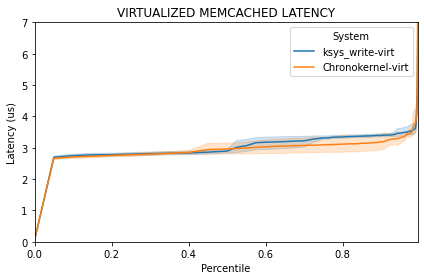

In [22]:
virt_memcached_all = virt_memcached_all + virt_sym_all

virt_memcached_data = pd.concat(virt_memcached_all, ignore_index=True)

fig = sns.lineplot(y="Value", x="Percentile", data=virt_memcached_data, hue="System")

fig.set(title="VIRTUALIZED MEMCACHED LATENCY")

plt.xlabel('Percentile')
plt.ylabel('Latency (us)')
plt.ylim(0,7)
plt.xlim(0,0.995)
plt.tight_layout()
plt.savefig('graphs/virt_avg_plt.png')


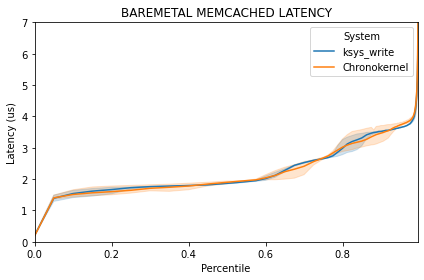

In [23]:
baremetal_memcached_all = baremetal_memcached_all + baremetal_sym_all

baremetal_memcached_data = pd.concat(baremetal_memcached_all, ignore_index=True)

fig = sns.lineplot(y="Value", x="Percentile", data=baremetal_memcached_data, hue="System")

fig.set(title="BAREMETAL MEMCACHED LATENCY")

plt.xlabel('Percentile')
plt.ylabel('Latency (us)')
plt.ylim(0,7)
plt.xlim(0,0.995)
plt.tight_layout()
plt.savefig('graphs/baremetal_avg_plt.png')

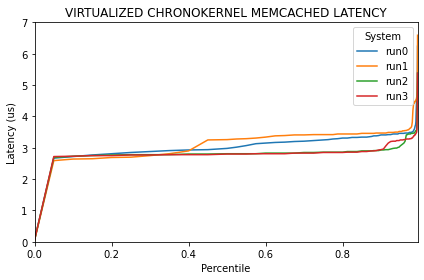

In [24]:
graph_data ={}
for i in range(0,4):
    graph_data[i] = pd.DataFrame(virt_sym[i],columns=['Percentile', 'Value', 'System'])
    graph_data[i] = graph_data[i][graph_data[i]["Percentile"] < 0.995].copy()

graph = pd.concat(graph_data, ignore_index=True)

fig = sns.lineplot(y="Value", x="Percentile", data=graph, hue="System")

fig.set(title="VIRTUALIZED CHRONOKERNEL MEMCACHED LATENCY")

plt.xlabel('Percentile')
plt.ylabel('Latency (us)')
plt.ylim(0,7)
plt.xlim(0,0.995)
plt.tight_layout()
plt.savefig("graphs/virt_chronokernel_run_plt.png")

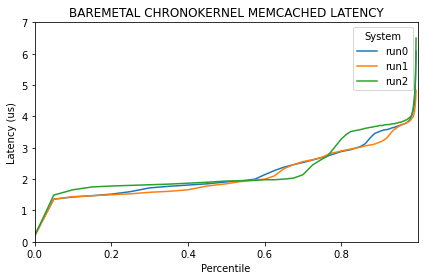

In [33]:
graph_data ={}
for i in range(0,3):
    graph_data[i] = pd.DataFrame(baremetal_sym[i],columns=['Percentile', 'Value', 'System'])
    graph_data[i] = graph_data[i][graph_data[i]["Percentile"] < 0.995].copy()

graph = pd.concat(graph_data, ignore_index=True)

fig = sns.lineplot(y="Value", x="Percentile", data=graph, hue="System")

fig.set(title="BAREMETAL CHRONOKERNEL MEMCACHED LATENCY")

plt.xlabel('Percentile')
plt.ylabel('Latency (us)')
plt.ylim(0,7)
plt.xlim(0,0.999)
plt.tight_layout()
plt.savefig("graphs/baremetal_chronokernel_run_plt.png")

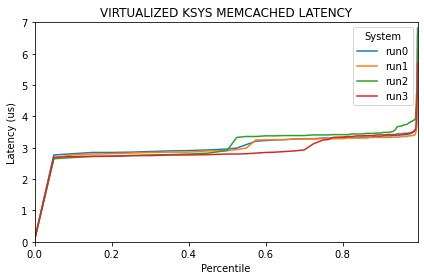

In [27]:
graph_data ={}
for i in range(0,4):
    graph_data[i] = pd.DataFrame(virt_ksys[i],columns=['Percentile', 'Value', 'System'])
    graph_data[i] = graph_data[i][graph_data[i]["Percentile"] < 0.995].copy()

graph = pd.concat(graph_data, ignore_index=True)

fig = sns.lineplot(y="Value", x="Percentile", data=graph, hue="System")

fig.set(title="VIRTUALIZED KSYS MEMCACHED LATENCY")

plt.xlabel('Percentile')
plt.ylabel('Latency (us)')
plt.ylim(0,7)
plt.xlim(0,0.995)
plt.tight_layout()
plt.savefig("graphs/virt_ksys_run_plt.png")

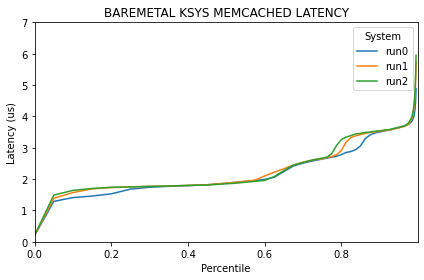

In [34]:
graph_data ={}
for i in range(0,3):
    graph_data[i] = pd.DataFrame(baremetal_ksys[i],columns=['Percentile', 'Value', 'System'])
    graph_data[i] = graph_data[i][graph_data[i]["Percentile"] < 0.995].copy()

graph = pd.concat(graph_data, ignore_index=True)

fig = sns.lineplot(y="Value", x="Percentile", data=graph, hue="System")

fig.set(title="BAREMETAL KSYS MEMCACHED LATENCY")

plt.xlabel('Percentile')
plt.ylabel('Latency (us)')
plt.ylim(0,7)
plt.xlim(0,0.999)
plt.tight_layout()
plt.savefig("graphs/baremetal_ksys_run_plt.png")

In [13]:
def build_throughput(group_name, title, cores=1):
    file_name = 'throughput_data/{}/{}/throughput_*.info'.format(cores,group_name)
    files = glob.glob(file_name)
    throughput = []
    for i in range(len(files)):
        graph = ["",""]
        f = open(files[i])
        graph[0] = "run" + str(i) #str(re.findall(r'\d+',file)[0])
        graph[1] = (f.readline().split())[0]
        throughput.append(graph)
    table = tabulate(throughput, headers=['Run #', 'Throughput (KB/s)'])
    print(title + "\n")
    print(table)

    tb_file = open("graphs/{}_throughput.txt".format(group_name), "w")
    tb_file.write(title + "\n\n")
    tb_file.write(table)
    tb_file.close()

In [14]:
build_throughput("virt_sym", "VIRTUALIZED MEMCACHED THROUGHPUT")
print("")
build_throughput("virt_ksys", "VIRTUALIZED SHORTCUTTED MEMCACHED THROUGHPUT")
print("")
build_throughput("baremetal_sym", "BAREMETAL MEMCACHED THROUGHPUT")
print("")
build_throughput("baremetal_ksys", "BAREMETAL SHORTCUTTED MEMCACHED THROUGHPUT")
print("")
build_throughput("redis_ksys", "BAREMETAL SHORTCUTTED REDIS THROUGHPUT")

VIRTUALIZED MEMCACHED THROUGHPUT

Run #      Throughput (KB/s)
-------  -------------------
run0                 5100.86
run1                 5080.63
run2                 4639.79
run3                 4727.86

VIRTUALIZED SHORTCUTTED MEMCACHED THROUGHPUT

Run #      Throughput (KB/s)
-------  -------------------
run0                 4896.9
run1                 4665.8
run2                 4748.41
run3                 4684.35

BAREMETAL MEMCACHED THROUGHPUT

Run #      Throughput (KB/s)
-------  -------------------
run0                 6831.51
run1                 6624.88

BAREMETAL SHORTCUTTED MEMCACHED THROUGHPUT

Run #      Throughput (KB/s)
-------  -------------------
run0                 6406.05
run1                 6670.3
run2                 6987.13

BAREMETAL SHORTCUTTED REDIS THROUGHPUT

Run #      Throughput (KB/s)
-------  -------------------
run0                 9372.68
run1                 9354.71
run2                 6913.21
